In [80]:
import numpy as np
import pandas as pd
import selenium as se
import seaborn as sns
import spacy
import openpyxl
import nltk
import ssl
import re
import os
import sklearn
import gensim
import en_core_web_lg

from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from nltk.corpus import words

# NLP stuff
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel
from spacy.pipeline import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [149]:
df_big_easy_clean = pd.read_csv('../data/processed_data/df_big_easy_clean.csv')
df_big_easy_clean.head()

,reviewBody,reviewRating,dateCreated,date_clean,review_clean
0,"Our server Marco, was on point with covid guid...",3.0,2 months ago,2021-06-06,server marco point covid guide lines service g...
1,Counter reservations apparently don't give you...,1.0,a year ago,2020-08-05,counter reservations apparently give table acc...
2,Good food. But there is a foul smell that find...,4.0,a year ago,2020-08-05,good food foul smell find every time times eve...
3,British pub with amazing line of draft beers -...,5.0,a year ago,2020-08-05,british pub amazing line draft beers truffel c...
4,"Waited for 15m to get served at the bar, wasti...",1.0,a year ago,2020-08-05,waited m get served bar wasting sizeable chunk...


In [150]:
df_big_easy_clean.shape

(614, 5)

# NLP stuff

### Basic analysis

<AxesSubplot:xlabel='reviewRating', ylabel='count'>

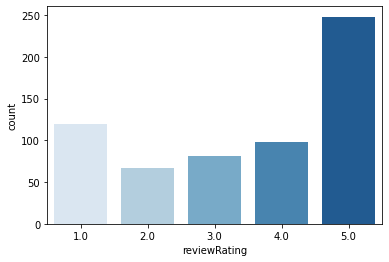

In [152]:
sns.countplot(data=df_big_easy_clean,
              x='reviewRating',
              palette='Blues')

Look over time

In [160]:
df_big_easy_clean['date_clean'] = df_big_easy_clean['date_clean'].astype('datetime64[D]')
df_monthly = df_big_easy_clean.set_index('date_clean').resample('M')['reviewRating'].agg(('mean','count'))
df_monthly #= df_monthly.query('')

,mean,count
date_clean,,
2020-08-31,3.581395,301
2020-09-30,4.000000,2
2020-10-31,4.222222,9
2020-11-30,3.755102,49
2020-12-31,3.304348,23
2021-01-31,3.400000,20
2021-02-28,5.000000,2
2021-03-31,2.333333,3
2021-04-30,5.000000,1


(187, 5)
(179, 5)
(248, 5)


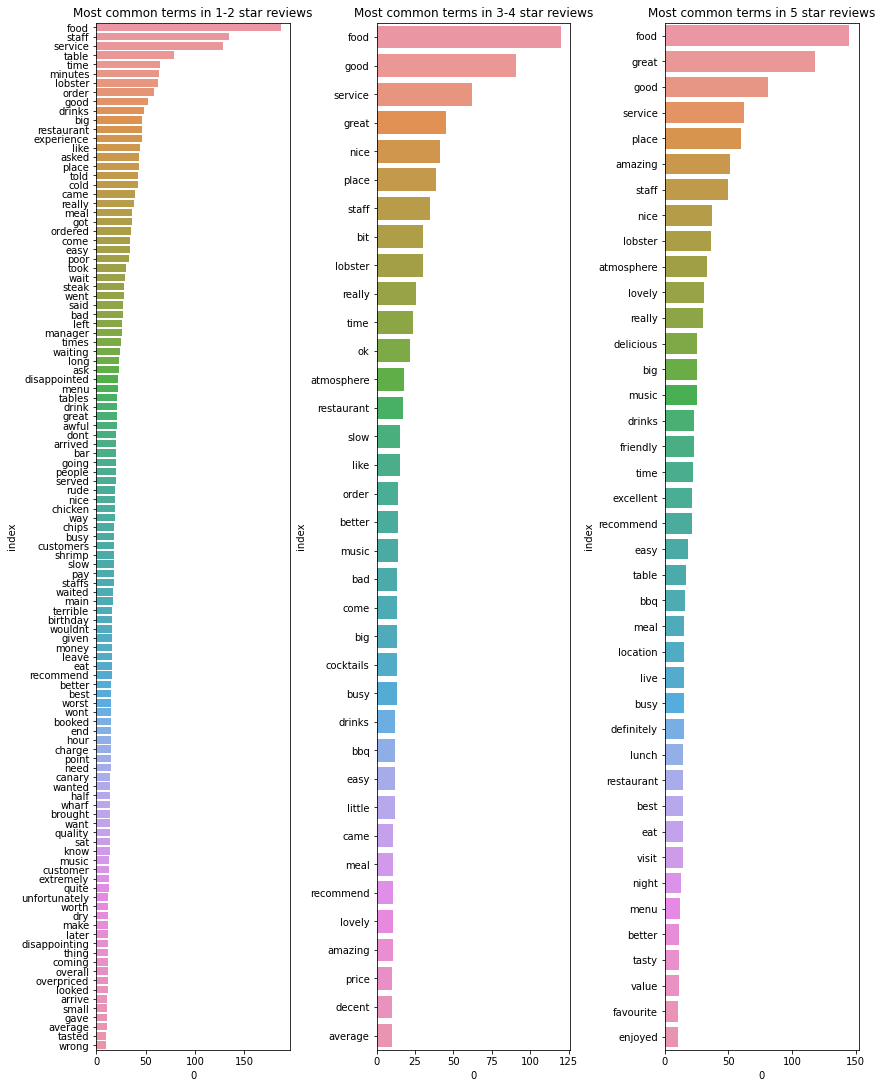

In [161]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,15),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_filt = df_big_easy_clean.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    print(df_filt.shape)
    
    # Set up vectorizer
    C = CountVectorizer(ngram_range=(1,1),
                        max_df=1.0,
                        min_df=10,
                        stop_words='english')
    
    # Get counts
    res = C.fit_transform(df_filt['review_clean'])
    
    # Set up dataframe
    df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())
    

    # Turn into plottable format
    df_plot = df_res.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')

In [241]:
df_big_easy_clean[df_big_easy_clean['review_clean'].str.contains('big easy')].shape

(49, 5)

(187, 97)
(179, 97)
(248, 97)


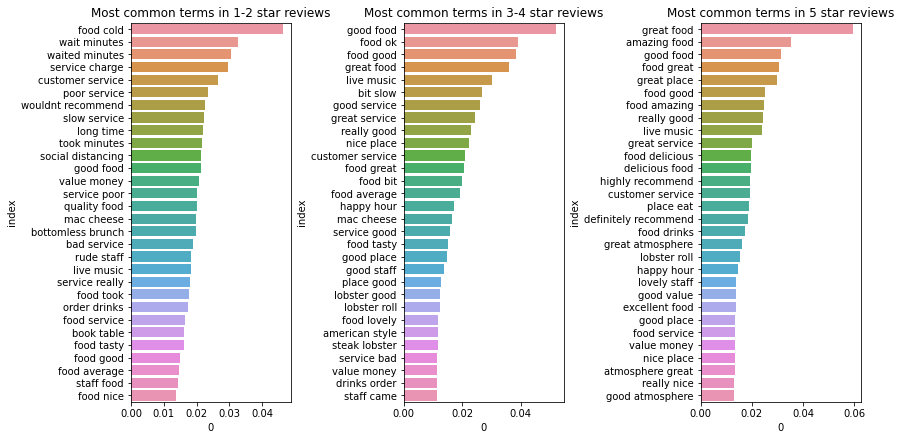

In [243]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,6),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

# Set up vectorizer
T = TfidfVectorizer(ngram_range=(2,2),
                    max_df=0.5,
                    min_df=5,
                    stop_words='english')

# Strip 'big easy' and 'canary wharf'
df_big_easy_clean['review_tfidf'] = [re.sub(r'(big easy|canary wharf)', '', s) for s in df_big_easy_clean['review_clean']]
    
# Get scores
res = T.fit_transform(df_big_easy_clean['review_tfidf'])

# Set up dataframe
df_res = pd.DataFrame(data=res.todense(),
                      columns=T.get_feature_names())

for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_res_filt = df_res[[r <= rev_max and r >= rev_min for r in df_big_easy_clean['reviewRating']]].copy(deep=True)
    print(df_res_filt.shape)
    
    # Turn into plottable format
    df_plot = df_res_filt.T.apply(lambda row: np.mean(row), axis=1).sort_values(ascending=False).reset_index()[:30]
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')

### Get co-occurrences of words (also known as collocations)

In [215]:
df_big_easy_clean['reviewBody'][6]

"Firstly, we had to queue for ages to be seated as there was only 1 member of staff checking reservations, taking temperatures and seating people. When my friend was downloading the track and trace app the attender tapped her phone which was an invasion on her personal space, and especially during this time. It also took quite a while to be served after being seated. The cocktails were extremely basic and watered down. Presentation was also poor, you could better looking cocktails and Whetherspoons. This is the 2nd time that I've been to Big Easy (last time I went to the one in Leicester Square) and both times my side of Mac & Cheese was forgotten. This time 3 different waiters came to ask if it had arrived and I just ended up cancelling it as I had already finished my starter and main. Overall the food was really good but that didn't save the overall experience."

In [232]:
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

BI_OR_TRI = 'bi'

# Get most common terms in 1-2, 3-4, and 5 star reviews
for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    print(f'\n\n***** Reviews in range {rev_min} to {rev_max} stars *****\n\n')
    
    # Filter for certain reviews
    df_filt = df_big_easy_clean.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    
    # Get corpus as list of all words in all reviews
    all_review_tokens = []
    for r in df_filt['review_clean']:
        to_exclude = ['canary', 'wharf', 'big', 'easy']
        all_review_tokens.extend([w for w in r.split() if w not in to_exclude])
    
    if BI_OR_TRI == 'bi':
        measures = BigramAssocMeasures()
        finder = BigramCollocationFinder.from_words(all_review_tokens, window_size=5)
    else:
        measures = TrigramAssocMeasures()
        finder = TrigramCollocationFinder.from_words(all_review_tokens, window_size=3) 

    # Ngrams with 'lobster' as a member
    word_filter = lambda *w: 'lobster' not in w
    
    print(df_filt.shape)

    # only bigrams that appear n+ times throughout all reviews
    finder.apply_freq_filter(5)
    
    # only bigrams that contain word filter
    # finder.apply_ngram_filter(word_filter)
    
    
    for idx, detail in enumerate(finder.score_ngrams(measures.likelihood_ratio)):
        #print(detail)
        (first, second) = detail[0]
        print(df_filt[(df_filt['review_clean'].str.contains(first))&(df_filt['review_clean'].str.contains(second))].shape[0],
              detail)
        if idx > 40:
            break
            
#     print('\nPMI')
#     for idx, detail in enumerate(finder.score_ngrams(measures.pmi)):
#         (first, second) = detail[0]
#         print(df_filt[(df_filt['review_clean'].str.contains(first))&(df_filt['review_clean'].str.contains(second))].shape[0],
#               detail)
#         if idx > 15:
#             break



***** Reviews in range 1 to 2 stars *****


(187, 5)
5 (('social', 'distancing'), 15.366009439800866)
6 (('mac', 'cheese'), 13.870431067796769)
30 (('food', 'cold'), 13.869668677723496)
10 (('waited', 'minutes'), 12.043841660543706)
7 (('wouldnt', 'recommend'), 11.082893195691192)
5 (('bottomless', 'brunch'), 10.87042504311582)
15 (('service', 'charge'), 10.41327139192419)
5 (('whole', 'experience'), 9.914646420219123)
7 (('live', 'music'), 9.720417324759534)
5 (('value', 'money'), 9.606190103605616)
34 (('wait', 'minutes'), 9.082982777942014)
21 (('service', 'poor'), 8.867981841168668)
8 (('worst', 'ever'), 8.832337412778323)
6 (('recommend', 'anyone'), 8.819805485793408)
11 (('took', 'arrive'), 8.248864798871308)
3 (('walked', 'away'), 7.541712895597588)
4 (('lobster', 'roll'), 7.487849430339965)
8 (('even', 'though'), 7.33930268934899)
18 (('first', 'time'), 6.6356332790681485)
5 (('steak', 'well'), 6.476214972503453)
17 (('long', 'time'), 6.192699955385855)
9 (('took', 'long'), 6

(4, 5)
(3, 5)
(4, 5)


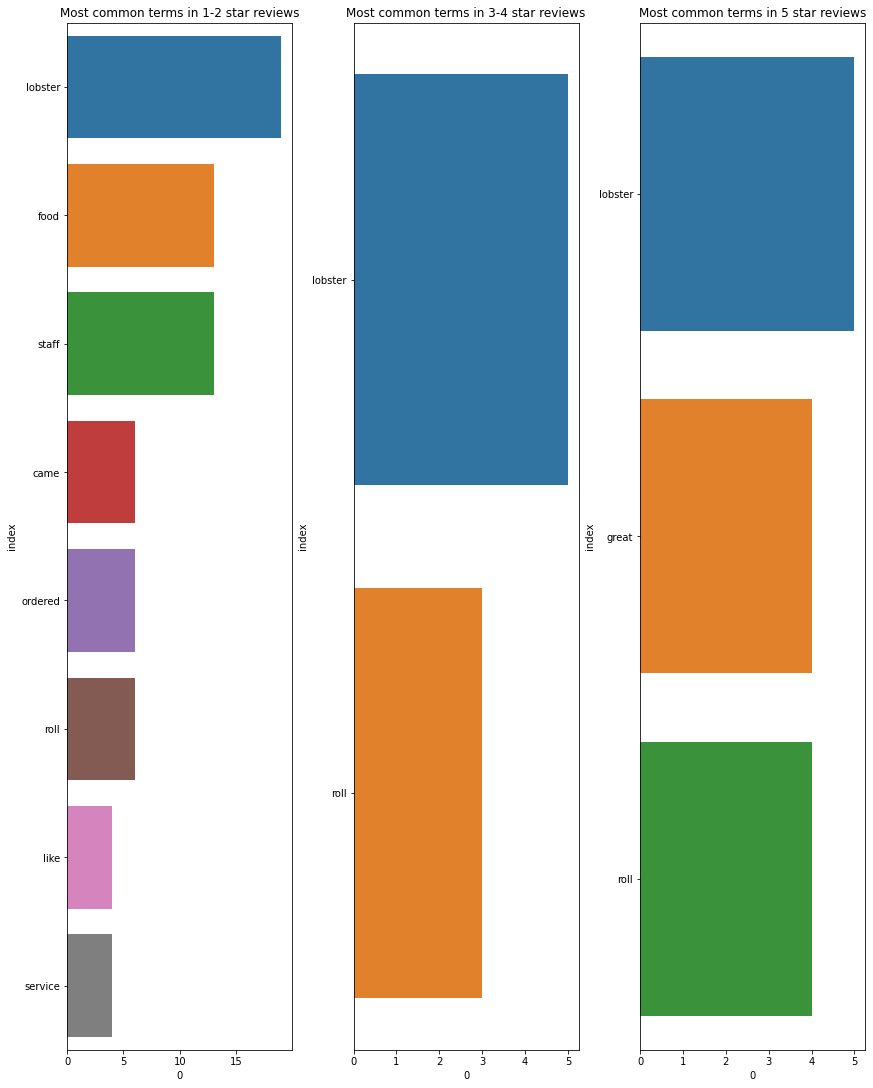

In [180]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,15),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

word_filt = 'lobster roll'

for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_filt = df_big_easy_clean.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    df_filt = df_filt[df_filt['reviewBody'].str.contains(word_filt)]
    print(df_filt.shape)
    
    # Set up vectorizer
    C = CountVectorizer(ngram_range=(1,1),
                        max_df=1.0,
                        min_df=3,
                        stop_words='english')
    
    # Get counts
    res = C.fit_transform(df_filt['review_clean'])
    
    # Set up dataframe
    df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())
    

    # Turn into plottable format
    df_plot = df_res.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')

I was abit dissapointed because it was my birthday and my boyfriend specifically told staff but they didnt acknowledge this. Food was ok except the ribs was abit under cook and dry so didnt finish it. 

They're not doing much for Birthday Celebrants! 

This restaurant was booked for me and my best friend as a birthday surprise, as well as various other things. In which I was not disappointed. Couldn't believe I hadn't heard of this place, I must be  

My partner had booked the restaurant for my 27th birthday as a surprise, we were very excited. On arrival, the receptionist was not wearing a mask & a couple of other staff were lowering their masks d 

Came here for my mother’s birthday, she’s been to the Covent Garden branch and loved it so we decided to come to canary wharf branch ABSOLUTELY HORRIBLE food was cold and bland won’t be returning. 

The worst experience ever, came out to celebrate my daughters birthday, food wasn't cook properly. Service was below standard, ask for Oreo mi

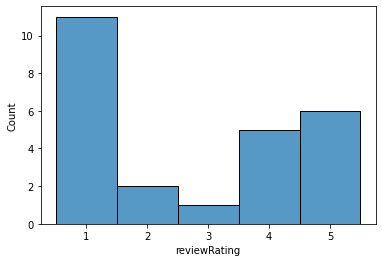

In [127]:
df_test = df_big_easy_clean.query(f'reviewRating>=1 and reviewRating<=5')
# df_test = df_test[(df_test['review_clean'].str.contains('lobster'))&(df_test['review_clean'].str.contains('roll'))]
df_test = df_test[df_test['review_clean'].str.contains('birthday')]
sns.histplot(df_test['reviewRating'],
             bins=[0.5,1.5,2.5,3.5,4.5,5.5])
for r in df_test['reviewBody']:
    print(r[:200], '\n')
#df_test[df_test['review_clean'].str.contains('lunch')]

In [167]:
weekday_ratings = []

day_prefixes = r'[a-z]{1,}day'
for idx, row in df_big_easy_clean.iterrows():
    matches = re.search(day_prefixes, row['reviewBody'].lower())
    if matches is not None:
        weekday_ratings.append([row['reviewRating'], matches.group()])
        print(row['reviewRating'], matches.group(), ':', row['reviewBody'][:300], '\n')
        
pd.DataFrame(weekday_ratings, columns=['rating', 
                                       'day']).groupby('day')['rating'].agg(('mean', 
                                                                             'count')).sort_values(by='count',
                                                                                                   ascending=False)

3.0 birthday : I was abit dissapointed because it was my birthday and my boyfriend specifically told staff but they didnt acknowledge this. Food was ok except the ribs was abit under cook and dry so didnt finish it. 

4.0 birthday : They're not doing much for Birthday Celebrants! 

5.0 birthday : This restaurant was booked for me and my best friend as a birthday surprise, as well as various other things. In which I was not disappointed. Couldn't believe I hadn't heard of this place, I must be living under a rock!! All four of us were seated, given our menus which and served pretty quickly. W 

2.0 tuesday : Restaurant was not busy, yet the service received was terrible. Food came pretty quickly, but the service after that was terrible. Tried to charge us for an additional meal, £25. Luckily I checked the bill. Took them HALF AN HOUR to rectify, then I was cheekily told it was a "system error". It was n 

5.0 today : Was really excited to be back here and was not disappointed. Great foo

,mean,count
day,,
birthday,2.869565,23
saturday,4.000000,10
tuesday,2.500000,8
today,2.857143,7
friday,2.166667,6
monday,4.000000,3
sunday,4.333333,3
bday,3.500000,2
weekday,5.000000,2


In [182]:
weekday_ratings = []

day_prefixes = r'(lunch|dinner)'
for idx, row in df_big_easy_clean.iterrows():
    matches = re.search(day_prefixes, row['reviewBody'].lower())
    if matches is not None:
        weekday_ratings.append([row['reviewRating'], matches.group()])
        print(row['reviewRating'], matches.group(), ':', row['reviewBody'][:300], '\n')
        
pd.DataFrame(weekday_ratings, columns=['rating', 
                                       'day']).groupby('day')['rating'].agg(('mean', 
                                                                             'count')).sort_values(by='count',
                                                                                                   ascending=False)

1.0 lunch : Waited for 15m to get served at the bar, wasting a sizeable chunk of my lunch break. Staff constantly stayed at other end of the bar, addressing customers who just appeared. Got annoyed and left. Express lunch, only if you managed to get the staff to even acknowledge you! 

5.0 dinner : This restaurant was booked for me and my best friend as a birthday surprise, as well as various other things. In which I was not disappointed. Couldn't believe I hadn't heard of this place, I must be living under a rock!! All four of us were seated, given our menus which and served pretty quickly. W 

5.0 lunch : It is a good place to be in lunch time, monday to friday, the express lunch is massive and good quality, if you take 2 courses with drink and service charge is about £15. I have to say that i've been there also in a weekend with my kids, in the website they saying ITS FREE MEAL FOR KIDS.....and it i 

5.0 lunch : The big easy is super! Great modern architecture definitely worth to v

,mean,count
day,,
lunch,4.000000,21
dinner,2.857143,14


### Entity recognition

Get english language and test parsing on one example

In [79]:
nlp = spacy.load("en_core_web_lg")

In [391]:
row = 47
doc = nlp(df_big_easy_eng.reset_index()['reviewBody'][row])

print(doc[:20], df_big_easy_eng.reset_index()['reviewRating'][row], sep='\n')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, spacy.explain(token.dep_),
            token.shape_, token.is_alpha, token.is_stop, sep=', ')

The atmosphere was good. The wings were delicious. I could not eat the brisket as it was so
2.0
The, the, DET, DT, det, determiner, Xxx, True, True
atmosphere, atmosphere, NOUN, NN, nsubj, nominal subject, xxxx, True, False
was, be, AUX, VBD, ROOT, None, xxx, True, True
good, good, ADJ, JJ, acomp, adjectival complement, xxxx, True, False
., ., PUNCT, ., punct, punctuation, ., False, False
The, the, DET, DT, det, determiner, Xxx, True, True
wings, wing, NOUN, NNS, nsubj, nominal subject, xxxx, True, False
were, be, AUX, VBD, ROOT, None, xxxx, True, True
delicious, delicious, ADJ, JJ, acomp, adjectival complement, xxxx, True, False
., ., PUNCT, ., punct, punctuation, ., False, False
I, I, PRON, PRP, nsubj, nominal subject, X, True, True
could, could, AUX, MD, aux, auxiliary, xxxx, True, True
not, not, PART, RB, neg, negation modifier, xxx, True, True
eat, eat, VERB, VB, ROOT, None, xxx, True, False
the, the, DET, DT, det, determiner, xxx, True, True
brisket, brisket, NOUN, NN, dobj, dire

Visualise dependencies

In [392]:
spacy.displacy.render(doc,
                      options={'compact':True})

In [393]:
spacy.displacy.render(doc, style='ent', jupyter=True)

Go one step further, and label data with dependencies

In [394]:
# Document is list of sentences, .sents is a generator object that allows us to grab these
sentences = list(doc.sents)

# Get function to extract information from sentences
def get_dependency_data(sentence):
    for word in sentence:
        output_prelim = f'{word} has '
        dep = word.dep_
        dep_first_letter = dep[0] if dep is not None else None

        if spacy.explain(dep) is not None:
            suffix = f'label {dep} ({spacy.explain(dep)})'
        else:
            suffix = f'label {dep}'
        
        print(output_prelim + suffix)
        

for s in sentences:
    get_dependency_data(s)
    print('---------------\n')
        
        

The has label det (determiner)
atmosphere has label nsubj (nominal subject)
was has label ROOT
good has label acomp (adjectival complement)
. has label punct (punctuation)
---------------

The has label det (determiner)
wings has label nsubj (nominal subject)
were has label ROOT
delicious has label acomp (adjectival complement)
. has label punct (punctuation)
---------------

I has label nsubj (nominal subject)
could has label aux (auxiliary)
not has label neg (negation modifier)
eat has label ROOT
the has label det (determiner)
brisket has label dobj (direct object)
as has label mark (marker)
it has label nsubj (nominal subject)
was has label advcl (adverbial clause modifier)
so has label advmod (adverbial modifier)
fatty has label acomp (adjectival complement)
. has label punct (punctuation)
---------------

The has label det (determiner)
waiter has label nsubj (nominal subject)
had has label ROOT
his has label poss (possession modifier)
mask has label dobj (direct object)
under has 

### LDA

Get counts for all 1-2 grams in reviews

In [348]:
# For topic analysis, remove very common terms that appear in every topic
reviews_less_stopwords = df_big_easy_clean['review_clean'].apply(lambda review: re.sub(r'(food)', '', review))

list_of_list_of_tokens = [rev.split() for rev in reviews_less_stopwords]
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

In [370]:
num_topics = 20
lda_model = LdaModel(corpus, 
                     num_topics=num_topics, 
                     id2word=dictionary_LDA, 
                     passes=3,
                     alpha=[0.01]*num_topics,
                     eta=[0.01]*len(dictionary_LDA.keys()))

for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.017*"great" + 0.016*"get" + 0.015*"service" + 0.013*"give" + 0.012*"staff" + 0.010*"good" + 0.010*"rib" + 0.009*"go" + 0.009*"its" + 0.008*"disappoint"

1: 0.032*"good" + 0.018*"service" + 0.018*"place" + 0.016*"great" + 0.015*"come" + 0.015*"go" + 0.013*"time" + 0.012*"restaurant" + 0.010*"it" + 0.009*"would"

2: 0.033*"great" + 0.028*"view" + 0.024*"staff" + 0.024*"good" + 0.024*"lovely" + 0.018*"excellent" + 0.018*"place" + 0.017*"really" + 0.017*"atmosphere" + 0.016*"back"

3: 0.022*"service" + 0.017*"nice" + 0.015*"table" + 0.015*"really" + 0.014*"go" + 0.014*"place" + 0.013*"us" + 0.013*"would" + 0.012*"restaurant" + 0.009*"friends"

4: 0.018*"table" + 0.016*"service" + 0.015*"good" + 0.014*"ask" + 0.014*"place" + 0.013*"order" + 0.012*"staff" + 0.012*"time" + 0.012*"come" + 0.011*"go"

5: 0.016*"lobster" + 0.015*"order" + 0.013*"come" + 0.013*"place" + 0.011*"good" + 0.010*"amaze" + 0.010*"go" + 0.009*"us" + 0.009*"also" + 0.009*"get"

6: 0.026*"us" + 0.018*"disappoint" + 0

7     68
9     65
3     48
4     43
2     38
15    37
19    34
1     33
11    31
16    26
12    24
5     23
17    22
8     22
0     19
18    19
10    17
14    17
13    15
6     13
Name: topic, dtype: int64


<AxesSubplot:xlabel='rating', ylabel='topic'>

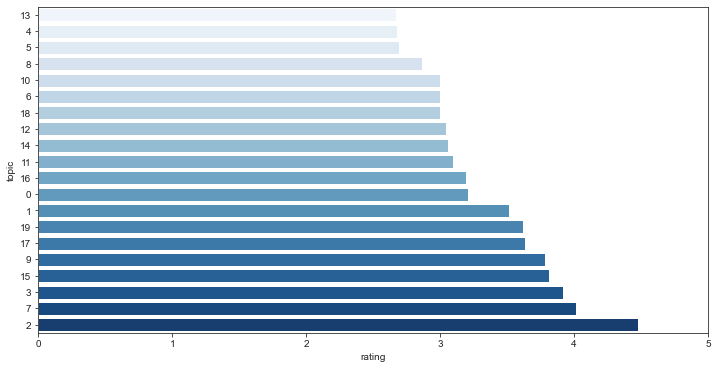

In [372]:
df_sentiment_by_topic = pd.DataFrame(data=sentiment_by_topic,
                                     columns=['rating', 'topic'])

df_sentiment_by_topic['topic'] = df_sentiment_by_topic['topic'].astype(str)

print(df_sentiment_by_topic['topic'].value_counts())


plt.figure(figsize=(12,6))
plt.xlim((0,5))

# Collapse
sns.barplot(data=df_sentiment_by_topic.groupby('topic')['rating'].mean().reset_index().sort_values(by='rating'),
              y='topic',
              x='rating',
            palette='Blues')

In [61]:
# %matplotlib inline
# import pyLDAvis
# import pyLDAvis.gensim_models
# vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
# pyLDAvis.enable_notebook()
# pyLDAvis.display(vis)